In [1]:
from lib.backbone import StackedHGNetV1
from lib.utility import get_dataloader

In [2]:
class Model_Config:
    def __init__(self):
        self.classes_num = [68, 9, 68]
        self.edge_info = (
                (False, (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)),  # FaceContour
                (False, (17, 18, 19, 20, 21)),  # RightEyebrow
                (False, (22, 23, 24, 25, 26)),  # LeftEyebrow
                (False, (27, 28, 29, 30)),  # NoseLine
                (False, (31, 32, 33, 34, 35)),  # Nose
                (True, (36, 37, 38, 39, 40, 41)),  # RightEye
                (True, (42, 43, 44, 45, 46, 47)),  # LeftEye
                (True, (48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59)),  # OuterLip
                (True, (60, 61, 62, 63, 64, 65, 66, 67)),  # InnerLip
            )
        self.nstack = 4
        self.add_coord = True
        self.decoder_type = "default"
        self.width = 256
        self.height = 256
        self.use_AAM = True

In [3]:
model_config = Model_Config()
net = StackedHGNetV1(config=model_config,
                        classes_num=model_config.classes_num,
                        edge_info=model_config.edge_info,
                        nstack=model_config.nstack,
                        add_coord=model_config.add_coord,
                        decoder_type=model_config.decoder_type)

In [4]:
net

StackedHGNetV1(
  (pre): Sequential(
    (0): CoordConvTh(
      (addcoords): AddCoordsTh()
      (conv): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu): ReLU()
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (relu): ReLU()
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (skip_layer): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size

In [5]:
class Data_Config:
    def __init__(self):
            self.data_definition = "300W"
            self.train_tsv_file = 'pub_annot/300W/train.tsv'
            self.val_tsv_file = 'pub_annot/300W/test.tsv'
            self.train_pic_dir = 'pub_dataset/300W'
            self.val_pic_dir = 'pub_dataset/300W'
            self.loader_type = 'alignment'
            self.batch_size = 16
            self.val_batch_size = 32
            self.train_num_workers = 1
            self.val_num_workers = 1
            self.width = 256
            self.height = 256
            self.channels = 3
            self.means = (127.5, 127.5, 127.5)
            self.scale = 0.00784313725490196
            self.classes_num = [68, 9, 68]
            self.crop_op = True
            self.aug_prob = 1.0
            self.label_num = 12
            self.edge_info = (
                (False, (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)),  # FaceContour
                (False, (17, 18, 19, 20, 21)),  # RightEyebrow
                (False, (22, 23, 24, 25, 26)),  # LeftEyebrow
                (False, (27, 28, 29, 30)),  # NoseLine
                (False, (31, 32, 33, 34, 35)),  # Nose
                (True, (36, 37, 38, 39, 40, 41)),  # RightEye
                (True, (42, 43, 44, 45, 46, 47)),  # LeftEye
                (True, (48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59)),  # OuterLip
                (True, (60, 61, 62, 63, 64, 65, 66, 67)),  # InnerLip
            )
            self.flip_mapping = ([0, 16], [1, 15], [2, 14], [3, 13], [4, 12], [5, 11], [6, 10], [7, 9], [17, 26], [18, 25], [19, 24], [20, 23], [21, 22], [31, 35], [32, 34], [36, 45], [37, 44], [38, 43], [39, 42], [40, 47], [41, 46], [48, 54], [49, 53], [50, 52], [61, 63], [60, 64], [67, 65], [58, 56], [59, 55])
            self.encoder_type = 'default'

            # Val
            self.norm_type = 'default'
            self.nme_left_index = 36
            self.nme_right_index = 45


In [6]:
data_config = Data_Config()
train_loader = get_dataloader(data_config, data_type='train', world_rank=0, world_size=1)
val_loader = get_dataloader(data_config, "val")

In [7]:
import numpy as np
import pandas as pd
import cv2
import re
import matplotlib.pyplot as plt
import torch

300W Original Label

In [8]:
train_label = pd.read_csv(data_config.train_tsv_file, sep="\t", header=None)

In [9]:
line = train_label[train_label.iloc[:,0].apply(lambda x: re.search(r'2838782176_1\.jpg',x)!=None)].iloc[0]

In [10]:
def get_label(line):
    image_path = line[0]
    landmarks_5pts = line[1]
    landmarks_5pts = np.array(list(map(float, landmarks_5pts.split(","))), dtype=np.float32).reshape(5, 2)
    landmarks_target = line[2]
    landmarks_target = np.array(list(map(float, landmarks_target.split(","))), dtype=np.float32).reshape(
        data_config.classes_num[0], 2)
    scale = float(line[3])
    center_w, center_h = float(line[4]), float(line[5])
    return image_path,landmarks_5pts,landmarks_target,scale,center_w,center_h

In [11]:
image_path,landmarks_5pts,landmarks_target,scale,center_w,center_h = get_label(line)

In [12]:
img = cv2.imread(image_path.replace('rawImages','pub_dataset/300W'), cv2.IMREAD_COLOR)

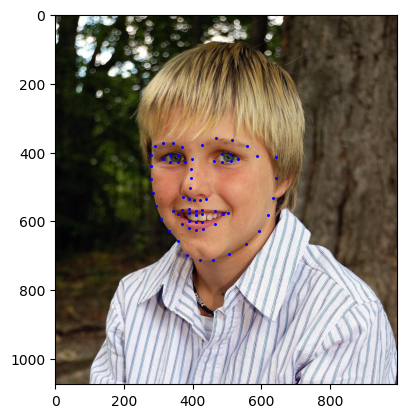

In [13]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(landmarks_target[:,0], landmarks_target[:,1], s=5, marker='.', c='b')

Processed Data

In [14]:
def denorm_points(points, h, w, align_corners=False):
    if align_corners:
        # [-1, +1] -> [0, SIZE-1]
        des_points = (points + 1) / 2 * torch.tensor([w - 1, h - 1]).to(points).view(1, 1, 2)
    else:
        # [-1, +1] -> [-0.5, SIZE-0.5]
        des_points = ((points + 1) * torch.tensor([w, h]).to(points).view(1, 1, 2) - 1) / 2
    return des_points

In [15]:
for batch,sample in enumerate(train_loader):
    break

In [16]:
i = 2
print(sample['data'][i].numpy().shape)
img = sample['data'][i]
len(sample['label']) # landmarks, heatmap, edgemap
landmarks, heatmaps, edgemaps = sample['label']
landmark = landmarks[i]
heatmap = heatmaps[i]
edgemap = edgemaps[i]
matrixs = sample['matrix']
matrix = matrixs[i]

(3, 256, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


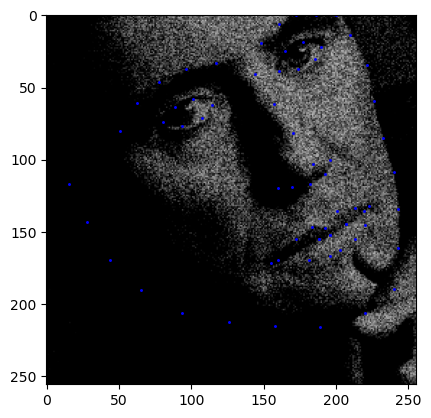

In [17]:
denorm_landmark = denorm_points(landmark,h=256,w=256).squeeze()
ori_img = cv2.cvtColor(img.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB) #'pub_dataset/300W/helen/trainset/2838782176_1.jpg'
plt.imshow(ori_img)
plt.scatter(denorm_landmark[:,0], denorm_landmark[:,1], s=5, marker='.', c='b')

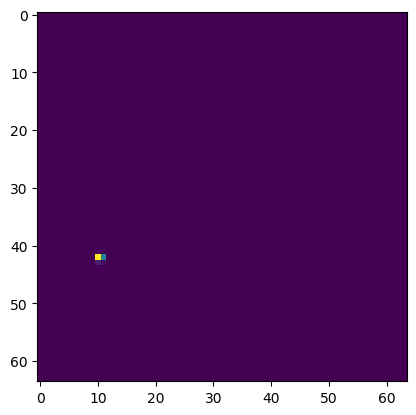

In [18]:
plt.imshow(heatmap[2], cmap='viridis', interpolation='nearest')

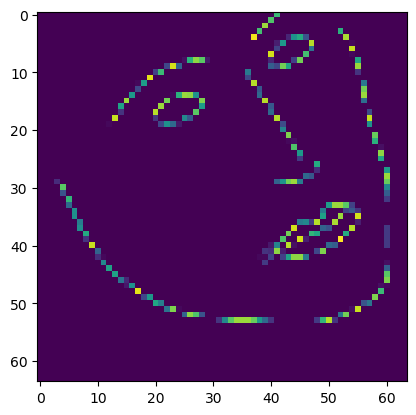

In [19]:
combined_edgemap = np.max(edgemap.numpy(), axis=0)
plt.imshow(combined_edgemap, cmap='viridis', interpolation='nearest')

In [20]:
# output, heatmaps, landmarks = net(sample['data'])
# output: [landmarks, pointmaps, edgemaps ] * nstack


In [21]:

import torch.nn.functional as F
from lib.loss import *
from lib.metric import NME, FR_AUC

In [22]:
class Train_Config:
    def __init__(self):
        # self.classes_num = [68, 9, 68]
        self.nstack = 4
        # self.add_coord = True
        # self.decoder_type = "default"
        # self.width = 256
        # self.height = 256
        self.use_AAM = True
        self.label_num = self.nstack * 3 if self.use_AAM else self.nstack

        self.loss_func = "STARLoss_v2"

        # STAR Loss paras
        self.star_w = 1
        self.star_dist = 'smoothl1'

        self.loss_weights, self.criterion_labels, self.metrics = self.set_criterions()
        self.criterions = self.get_criterions()

        self.batch_weight = 1.0

        self.optimizer = "adam"
        self.learn_rate = 0.001
        self.weight_decay = 0.00001
        self.betas = [0.9, 0.999]
        self.gamma = 0.1
        self.milestones = [1,2,3]

    def set_criterions(self):
        loss_weights, criterions, metrics = [], [], []
        for i in range(self.nstack):
            factor = (2 ** i) / (2 ** (self.nstack - 1))
            if self.use_AAM:
                loss_weights += [factor * weight for weight in [1.0, 10.0, 10.0]]
                criterions += [self.loss_func, "AWingLoss", "AWingLoss"]
                metrics += ["NME", None, None]
            else:
                loss_weights += [factor * weight for weight in [1.0]]
                criterions += [self.loss_func, ]
                metrics += ["NME", ]
        return loss_weights, criterions, metrics
    
    def get_criterions(self):
        criterions = []
        for k in range(self.label_num):
            label = self.criterion_labels[k]
            if label == "AWingLoss":
                criterion = AWingLoss()
            elif label == "smoothl1":
                criterion = SmoothL1Loss()
            elif label == "l1":
                criterion = F.l1_loss
            elif label == 'l2':
                criterion = F.mse_loss
            elif label == "STARLoss":
                criterion = STARLoss(dist=self.star_dist, w=self.star_w)
            elif label == "STARLoss_v2":
                criterion = STARLoss_v2(dist=self.star_dist, w=self.star_w)
            else:
                assert False
            criterions.append(criterion)
        return criterions

In [23]:
train_config = Train_Config()

In [24]:
import lightning as L
from lib.metric import NME, FR_AUC

In [25]:

# define the LightningModule
class LitSTAR(L.LightningModule):
    def __init__(self, net, data_config, model_config, train_config):
        super().__init__()
        self.net = net
        self.data_config = data_config
        self.model_config = model_config
        self.train_config = train_config
        self.ave_losses = [0] * self.train_config.label_num
        self.list_nmes = [[] for i in range(self.data_config.label_num)]
        
    def training_step(self, sample, batch_idx):

        imgs = sample["data"].float()

        labels = []
        if isinstance(sample["label"], list):
            for label in sample["label"]:
                label = label.float()
                labels.append(label)
        else:
            label = sample["label"].float()
            for k in range(label.shape[1]):
                labels.append(label[:, k])
        labels = model_config.nstack * labels

        # forward
        output, heatmaps, landmarks = self.net(imgs)


        losses, sum_loss = self.compute_loss(output, labels, heatmaps, landmarks)
        self.ave_losses = list(map(sum, zip(self.ave_losses, losses)))
        avg_loss = sum(losses) / len(losses)
        # Logging to TensorBoard (if installed) by default
        self.log("sum_loss", sum_loss, prog_bar=True)
        self.log("AVG_loss",avg_loss,prog_bar=True)
        return sum_loss
    
    def validation_step(self,sample,batch_idx):
        
        metric_nme = NME(nme_left_index=self.data_config.nme_left_index, nme_right_index=self.data_config.nme_right_index)
        metric_fr_auc = FR_AUC(data_definition=self.data_config.data_definition)

        output_pd = None

        imgs = sample["data"].float()

        labels = []
        if isinstance(sample["label"], list):
            for label in sample["label"]:
                label = label.float()
                labels.append(label)
        else:
            label = sample["label"].float()
            for k in range(label.shape[1]):
                labels.append(label[:, k])
        labels = model_config.nstack * labels

        # forward
        output, heatmaps, landmarks = self.net(imgs)

        for k in range(self.data_config.label_num):
            if self.train_config.metrics[k] is not None:
                self.list_nmes[k] += metric_nme.test(output[k], labels[k])

    def on_validation_epoch_end(self):
        metric_nme = NME(nme_left_index=self.data_config.nme_left_index, nme_right_index=self.data_config.nme_right_index)
        metric_fr_auc = FR_AUC(data_definition=self.data_config.data_definition)
        metrics = [[torch.mean(torch.tensor(nmes)), ] + metric_fr_auc.test(torch.tensor(nmes)) for nmes in self.list_nmes]

        # self.log("Val_metrics",metrics)
        for k, metric in enumerate(metrics):
            nme, fr, auc = metric
            print(metric)
            if (nme is not None) and (fr is not None) and (auc is not None):
                stack_no = k//3
                self.log(f"Stack{stack_no}_NME",nme,on_epoch=True)
                self.log(f"Stack{stack_no}_FR",fr,on_epoch=True)
                self.log(f"Stack{stack_no}_AUC",auc,on_epoch=True)
                print("Val/Metric{:3d} in this epoch: [NME {:.6f}, FR {:.6f}, AUC {:.6f}]".format(
                    k, metric[0], metric[1], metric[2]))

        self.list_nmes = [[] for i in range(self.data_config.label_num)]


    def compute_loss(self, output, labels, heatmap=None, landmarks=None):
        batch_weight = self.train_config.batch_weight
        sum_loss = 0
        losses = list()
        # print(self.train_config.criterion_labels)
        for k in range(self.train_config.label_num):
            
            if self.train_config.criterion_labels[k] in ['smoothl1', 'l1', 'l2', 'WingLoss', 'AWingLoss']:
                loss = self.train_config.criterions[k](output[k], labels[k])
            elif self.train_config.criterion_labels[k] in ["STARLoss", "STARLoss_v2"]:
                _k = int(k / 3) if self.train_config.use_AAM else k
                loss = self.train_config.criterions[k](heatmap[_k], labels[k])
            else:
                assert NotImplementedError
            loss = batch_weight * loss
            sum_loss += self.train_config.loss_weights[k] * loss
            losses.append(loss)
        return losses, sum_loss

    def configure_optimizers(self):
        params = self.net.parameters()

        optimizer = None
        if self.train_config.optimizer == "sgd":
            optimizer = torch.optim.SGD(
                params,
                lr=self.train_config.learn_rate,
                momentum=self.train_config.momentum,
                weight_decay=self.train_config.weight_decay,
                nesterov=self.train_config.nesterov)
        elif self.train_config.optimizer == "adam":
            optimizer = torch.optim.Adam(
                params,
                lr=self.train_config.learn_rate)
        elif self.train_config.optimizer == "rmsprop":
            optimizer = torch.optim.RMSprop(
                params,
                lr=self.train_config.learn_rate,
                momentum=self.train_config.momentum,
                alpha=self.train_config.alpha,
                eps=self.train_config.epsilon,
                weight_decay=self.train_config.weight_decay
            )
        else:
            assert False

        config_dict = {
            "optimizer" : optimizer,
            "lr_scheduler" : {
                "scheduler" : torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.train_config.milestones, gamma=self.train_config.gamma)
            }
        }
        return config_dict


# init the module
STAR = LitSTAR(net, data_config, model_config, train_config)

In [26]:
from lightning.pytorch.callbacks import LearningRateMonitor
lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [28]:
trainer = L.Trainer(max_epochs=10,limit_train_batches = 5,log_every_n_steps=50,callbacks=[lr_monitor])
trainer.fit(model=STAR, train_dataloaders=train_loader,val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
train_config.metrics

['NME', None, None, 'NME', None, None, 'NME', None, None, 'NME', None, None]

In [56]:
output[0].shape[0]

NameError: name 'output' is not defined

In [ ]:
for batch_id,sample in enumerate(val_loader):
    break

In [ ]:
sample['label']